# Import Libraries

In [41]:
import os
import zipfile
import shutil
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import load_model
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
from google.colab import drive
from google.colab import files
from tensorflow.keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D


# Dataset Path

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
source_dir = '/content/drive/My Drive/Dataset/garbage_classification'

# Split Data

In [17]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for category in categories:
        # Make new directories for training, validation, and testing within each category
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Get all files in the current category
        files = os.listdir(os.path.join(source_dir, category))
        np.random.shuffle(files)  # Shuffle files to randomize

        # Split files according to provided ratios
        train_end = int(len(files) * train_size)
        val_end = train_end + int(len(files) * val_size)

        # Train files
        for f in files[:train_end]:
            shutil.copy(os.path.join(source_dir, category, f), os.path.join(train_dir, category, f))

        # Validation files
        for f in files[train_end:val_end]:
            shutil.copy(os.path.join(source_dir, category, f), os.path.join(val_dir, category, f))

        # Test files
        for f in files[val_end:]:
            shutil.copy(os.path.join(source_dir, category, f), os.path.join(test_dir, category, f))

In [18]:
train_dir = '/content/drive/My Drive/Dataset/train'
valid_dir = '/content/drive/My Drive/Dataset/valid'
test_dir = '/content/drive/My Drive/Dataset/test'

In [19]:

# Ensure the target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Apply the function to each category of images if needed
split_data(source_dir, train_dir, valid_dir, test_dir)

# Load Data

In [20]:
def count_image(directory):
  count = sum(len(files) for _, _, files in os.walk(directory))
  return count

train_count = count_image(train_dir)
valid_count = count_image(valid_dir)
test_count = count_image(test_dir)

print("Number of training data:", train_count)
print("Number of validation data:", valid_count)
print("Number of testing data:", test_count)

Number of training data: 14946
Number of validation data: 2958
Number of testing data: 2979


In [8]:
print("Files in training directory:", os.listdir(train_dir))
print("Files in validation directory:", os.listdir(valid_dir))
print("Files in testing directory:", os.listdir(test_dir))

Files in training directory: ['cardboard', 'paper', 'battery', 'green-glass', 'metal', 'biological', 'shoes', 'clothes', 'plastic', 'brown-glass', 'trash', 'white-glass']
Files in validation directory: ['cardboard', 'paper', 'battery', 'green-glass', 'metal', 'biological', 'shoes', 'clothes', 'plastic', 'brown-glass', 'trash', 'white-glass']
Files in testing directory: ['cardboard', 'paper', 'battery', 'green-glass', 'metal', 'biological', 'shoes', 'clothes', 'plastic', 'brown-glass', 'trash', 'white-glass']


# Data Augmentation

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   rotation_range=60,
                                   zoom_range=0.3,
                                   fill_mode='nearest'
                                  )


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255.)

validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important to keep the order consistent
)

Found 14946 images belonging to 12 classes.
Found 2958 images belonging to 12 classes.
Found 2979 images belonging to 12 classes.


# Model

In [29]:

def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[-100:]:
        layer.trainable=True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(12, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    return model

In [30]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [31]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs is None:
            logs = {}
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98:
                print('\nTarget telah tercapai, berhenti!!')
                self.model.stop_training = True

callbacks = MyCallback()

In [32]:
model.compile(optimizer =keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history=model.fit(train_generator,
                  epochs=50,
                  validation_data=validation_generator,
                  callbacks=[callbacks, early_stopping]
                 )

Epoch 1/50
468/468 [==============================] - 287s 469ms/step - loss: 1.6442 - accuracy: 0.5214 - val_loss: 3.8863 - val_accuracy: 0.1396
Epoch 2/50
468/468 [==============================] - 211s 450ms/step - loss: 1.6257 - accuracy: 0.4951 - val_loss: 1.3745 - val_accuracy: 0.5578
Epoch 3/50
468/468 [==============================] - 217s 464ms/step - loss: 1.2358 - accuracy: 0.6022 - val_loss: 1.5447 - val_accuracy: 0.5690
Epoch 4/50
468/468 [==============================] - 214s 457ms/step - loss: 1.2244 - accuracy: 0.6053 - val_loss: 0.9814 - val_accuracy: 0.6629
Epoch 5/50
468/468 [==============================] - 215s 460ms/step - loss: 1.0419 - accuracy: 0.6631 - val_loss: 1.2746 - val_accuracy: 0.6247
Epoch 6/50
468/468 [==============================] - 219s 468ms/step - loss: 0.9162 - accuracy: 0.7092 - val_loss: 1.1477 - val_accuracy: 0.6602
Epoch 7/50
468/468 [==============================] - 214s 457ms/step - loss: 0.9094 - accuracy: 0.7164 - val_loss: 0.7317 -

# Data Visualization

In [34]:
histo = pd.DataFrame(history.history)
histo

,loss,accuracy,val_loss,val_accuracy
0,1.644168,0.521410,3.886342,0.139621
1,1.625718,0.495116,1.374465,0.557809
2,1.235814,0.602235,1.544713,0.568965
3,1.224356,0.605312,0.981439,0.662948
4,1.041857,0.663121,1.274612,0.624746
5,0.916215,0.709153,1.147704,0.660243
6,0.909359,0.716379,0.731716,0.746450
7,0.799872,0.750502,0.523321,0.826234
8,0.730369,0.773451,0.692529,0.782285
9,0.671727,0.791516,0.969028,0.710953


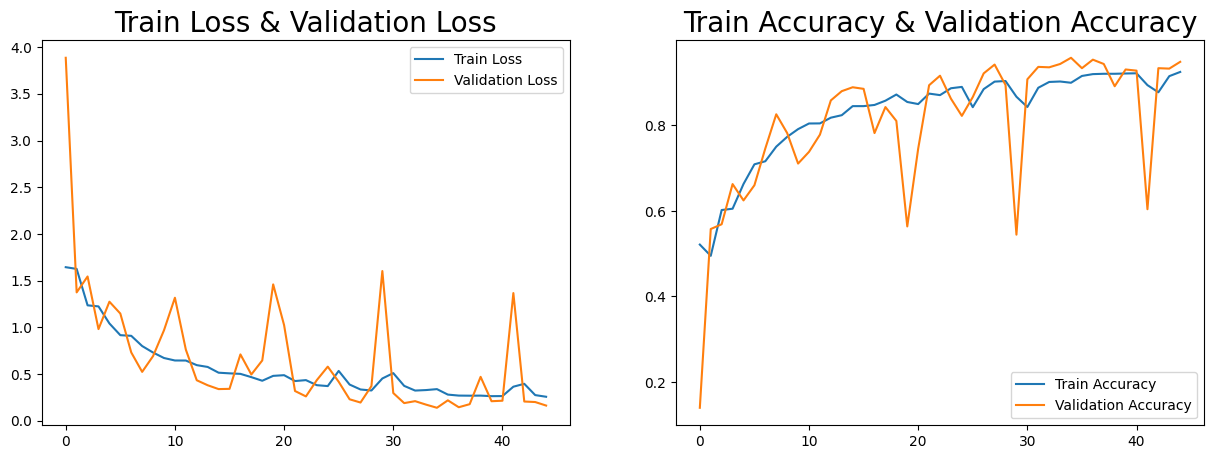

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(histo['loss'],label='Train Loss')
plt.plot(histo['val_loss'],label='Validation Loss')
plt.title('Train Loss & Validation Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histo['accuracy'],label='Train Accuracy')
plt.plot(histo['val_accuracy'],label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy',fontsize=20)
plt.legend()

In [36]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss: .4f}')
print(f'Test accuracy: {test_accuracy * 100:2f}%')

187/187 [==============================] - 13s 70ms/step - loss: 0.1292 - accuracy: 0.9601
Test loss:  0.1292
Test accuracy: 96.005368%


# Predict

In [37]:
model.save('recratify_model.h5')

In [38]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale image
    return img_array

# Predict image
def predict_image(model, img_path, class_labels):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label, predictions[0][predicted_class_index]

In [39]:
img_path = '/content/drive/My Drive/Dataset/test/battery/battery499.jpg'
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [42]:
model = load_model('recratify_model.h5')

predicted_class, confidence = predict_image(model, img_path, class_labels)
print(f'Predicted class: {predicted_class} with confidence: {confidence}')

1/1 [==============================] - 4s 4s/step
Predicted class: battery with confidence: 0.9994271993637085
